In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load and Process the Data

In [2]:
data = np.loadtxt('data/data.csv', delimiter=',')

The last 13 rows of the data represent my output

In [3]:
X = np.transpose(data[:-13,:])
Y = np.transpose(data[-13:,:])

Every channel has a background of around ~150. We don't want to factor that in. Output should always be positive, so these have been scaled in the range $\left[0,1\right]$.

In [4]:
X.shape

(140, 11725)

In [5]:
inscale = MinMaxScaler()
outscale = MinMaxScaler()

In [6]:
xs = inscale.fit_transform(X)
ys = outscale.fit_transform(Y)

Split the data into **train**, **test**, and **val**idation segments.

The data are in blocks of 20 measurements for each sample. Since the samples should be independent of each other, we can randomly select from each of the 7 samples. I have elected for a 70/15/15 train/test/validate split. 

*Should my output layer be linear (to try and estimate the amount of material in a spectrum) or LogSig/Softmax (material present or not)*

*Can't use hardlim with backpropagation because it is not differentiable*

*Softmax--multiclassification problem*

In [7]:
# Choose 6 random numbers from 1-20.
c = np.random.choice(range(20), 6, replace=False)

# Make these the indexes we will use for our test/validation
while c.shape[0] <= (xs.shape[0] - 6) * 0.3:
    c = np.concatenate((c, c[-6:]+20))

In [8]:
xs_test = np.array([xs[i, :] for i in c[::2]])
ys_test = np.array([ys[i, :] for i in c[::2]])
xs_val = np.array([xs[i, :] for i in c[1::2]])
ys_val = np.array([ys[i, :] for i in c[1::2]])
xs_train = np.delete(xs, c, 0)
ys_train = np.delete(ys, c, 0)
print(xs_test.shape)
print(ys_test.shape)
print(xs_val.shape)
print(ys_val.shape)
print(xs_train.shape)
print(ys_train.shape)

(21, 11725)
(21, 13)
(21, 11725)
(21, 13)
(98, 11725)
(98, 13)


We now have 98 training records, 21 testing records, and 21 validation records. Each record is a vector of 11725 input values and 13 output values.

# Goals #
There are three goals for this project. In increasing order of difficulty (and desirability), they are:

1. Classify which of the 7 candidate materials was present in the sample (with a confidence measurement)
2. Identify the presence or absence of one or more of the constituent materials in a sample
3. Identify the amount of each material that is present in a sample

# Goal \#1 #

The goal of this is to determine which of seven candidates a new sample matches. It should produce a classification and (ideally) a confidence prediction. For this, a radial basis function network was chosen. Since each spectra has 11725 (!) values, that is the number of input neurons. Since there are 7 potential candidates, that is the number of neurons in the hidden layer, and the number of neurons in the output layer.

## Attempt \#1 ##
Use 7 hidden neurons in the hidden layer; set them based on an average of all of the spectra of each sample.

For each sample we have 14 spectra. Reshape the input data into bins of 7 x 14 x 11725, then average along each sample to create representative spectra for the hidden layer.

In [9]:
tmp = np.reshape(xs_train, (7,14,11725))
avg_spectra = np.mean(tmp, 1)

Define a `tf.constant` for each sample array in avg_spectra

In [10]:
samples = np.array([tf.constant(avg_spectra[i,:], name="spectrum{}".format(i)) for i in range(avg_spectra.shape[0])])

In [11]:
x = tf.placeholder(tf.float32, [None, 11725])

Set up our weights

In [12]:
W = tf.Variable(tf.zeros([11725, 7]))
b = tf.Variable(tf.zeros([7]))

In [13]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [82]:
def rbf(x, p, beta=0.01):
    return np.exp(- beta * (np.linalg.norm(x - p)))

In [83]:
rbf(avg_spectra[0], xs_train[0])

0.86928386444423011

In [84]:
rbf(avg_spectra[0, :], xs_train[-1, :])

0.72285111749617548

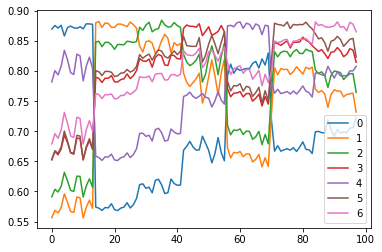

In [85]:
for i in range(7):
    plt.plot([rbf(avg_spectra[i], xs_train[j,:]) for j in range(xs_train.shape[0])], label=i)
plt.legend(loc='lower right')
plt.show()

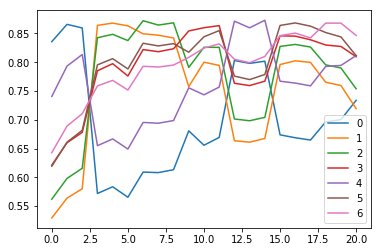

In [86]:
for i in range(7):
    plt.plot([rbf(avg_spectra[i], xs_test[j,:]) for j in range(xs_test.shape[0])], label=i)
plt.legend(loc='lower right')
plt.show()

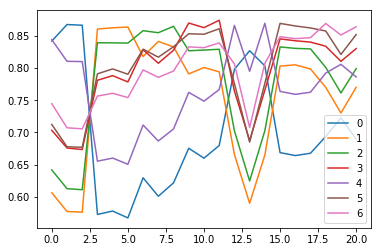

In [87]:
for i in range(7):
    plt.plot([rbf(avg_spectra[i], xs_val[j,:]) for j in range(xs_val.shape[0])], label=i)
plt.legend(loc='lower right')
plt.show()

Let's just try to get our math first

In [65]:
# phi = tf.constant(avg_spectra, dtype=tf.float32, name='samples')
phi = tf.Variable(tf.float32, name='phi')
beta = tf.constant(1., dtype=tf.float32, name='beta')
x = tf.placeholder(tf.float32, [None, 11725])
a = tf.subtract(phi, x)
b = tf.square(a)
c = tf.multiply(-1., beta)
d = tf.multiply(c, b)
e = tf.exp(d)
rbf = tf.reduce_sum(e, 1, name='rbf')
print(rbf)

Tensor("rbf:0", dtype=float32)


In [ ]:
def rbf_place(phi_array):
    # phi = tf.constant(avg_spectra, dtype=tf.float32, name='samples')
    phi = tf.Variable(tf.float32, name='phi')
    beta = tf.constant(1., dtype=tf.float32, name='beta')
    x = tf.placeholder(tf.float32, [None, 11725])
    a = tf.subtract(phi, x)
    b = tf.square(a)
    c = tf.multiply(-1., beta)
    d = tf.multiply(c, b)
    e = tf.exp(d)
    rbf = tf.reduce_sum(e, 1, name='rbf')
    print(rbf)

In [69]:
rbf0 = rbf({phi: avg_spectra[0]})

TypeError: 'Tensor' object is not callable

In [51]:
# Tensorflow stuff
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [68]:
plt.plot(sess.run(rbf, {x: xs_train, phi: avg_spectra}))
plt.show()

InvalidArgumentError: Incompatible shapes: [7,11725] vs. [98,11725]
	 [[Node: Sub_6 = Sub[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_phi_1_0_1, _arg_Placeholder_7_0_0)]]

Caused by op 'Sub_6', defined at:
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-65-73a7b737557b>", line 5, in <module>
    a = tf.subtract(phi, x)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 305, in subtract
    return gen_math_ops._sub(x, y, name)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2501, in _sub
    result = _op_def_lib.apply_op("Sub", x=x, y=y, name=name)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/jrpl/anaconda/envs/libs/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [7,11725] vs. [98,11725]
	 [[Node: Sub_6 = Sub[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_phi_1_0_1, _arg_Placeholder_7_0_0)]]


In [48]:
rbf(avg_spectra[0], xs_train[0])

11533.505873100094

In [49]:
print(phi)

Tensor("samples:0", shape=(7, 11725), dtype=float32)


In [55]:
a = np.arange(0,9,1).reshape((3,3))
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [59]:
b = np.transpose(np.arange(0,3,1))
b

array([0, 1, 2])

In [63]:
np.transpose(np.transpose(a) - np.transpose(b))

array([[0, 1, 2],
       [2, 3, 4],
       [4, 5, 6]])